In [1]:
%matplotlib inline
import sys
sys.path.append('..')

# Un vistazo a los datos
Vamos a cargar el vector de características.
    
Nota: las características tienen una nomenclatura del tipo "x_característica", donde x es un número, para mantener el orden original después de cambiar la nomenclatura del vector para ser consistente con el resto.

In [2]:
from dns_attacks_detection import *

In [3]:
try:
    dns = joblib.load('../vectors/EntropyAndRatiosFV_15NOV.pkl')
except FileNotFoundError:
    dns_exf = create_feature_vector_from_log_file('../logs/15NOV_Exf.log', extract_features_entropy_and_ratios)
    dns_tunn = create_feature_vector_from_log_file_tunnelling('../logs/15NOV_Tunn.log', extract_features_entropy_and_ratios)
    dns = pd.concat([dns_exf, dns_tunn], ignore_index=True)
    joblib.dump(dns, '../vectors/EntropyAndRatiosFV_15NOV.pkl')

In [4]:
dns.head()

,0_letters,1_numbers,2_entropy,3_longest_letters,4_longest_number,5_longest_meaningful,6_symbols,attack
0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0
1,0.666667,0.333333,0.528321,0.666667,0.333333,0.333333,0.0,0
2,1.000000,0.000000,0.401051,1.000000,0.000000,0.857143,0.0,0
3,0.000000,1.000000,0.500000,0.000000,1.000000,0.000000,0.0,0
4,1.000000,0.000000,0.298747,1.000000,0.000000,1.000000,0.0,0


In [5]:
dns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66237 entries, 0 to 66236
Data columns (total 8 columns):
0_letters               66237 non-null float64
1_numbers               66237 non-null float64
2_entropy               66237 non-null float64
3_longest_letters       66237 non-null float64
4_longest_number        66237 non-null float64
5_longest_meaningful    66237 non-null float64
6_symbols               66237 non-null float64
attack                  66237 non-null int64
dtypes: float64(7), int64(1)
memory usage: 4.0 MB


In [6]:
dns.describe()

,0_letters,1_numbers,2_entropy,3_longest_letters,4_longest_number,5_longest_meaningful,6_symbols,attack
count,66237.000000,66237.000000,66237.000000,66237.000000,66237.000000,66237.000000,66237.000000,66237.000000
mean,0.758232,0.239646,0.349015,0.727040,0.205496,0.505175,0.002123,0.237994
std,0.352308,0.352731,0.144014,0.381661,0.327710,0.358158,0.017798,0.425859
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.270969,0.375000,0.000000,0.142857,0.000000,0.000000
50%,1.000000,0.000000,0.360234,1.000000,0.000000,0.500000,0.000000,0.000000
75%,1.000000,0.500000,0.500000,1.000000,0.333333,0.875000,0.000000,0.000000
max,1.000000,1.000000,0.528321,1.000000,1.000000,1.000000,0.250000,1.000000


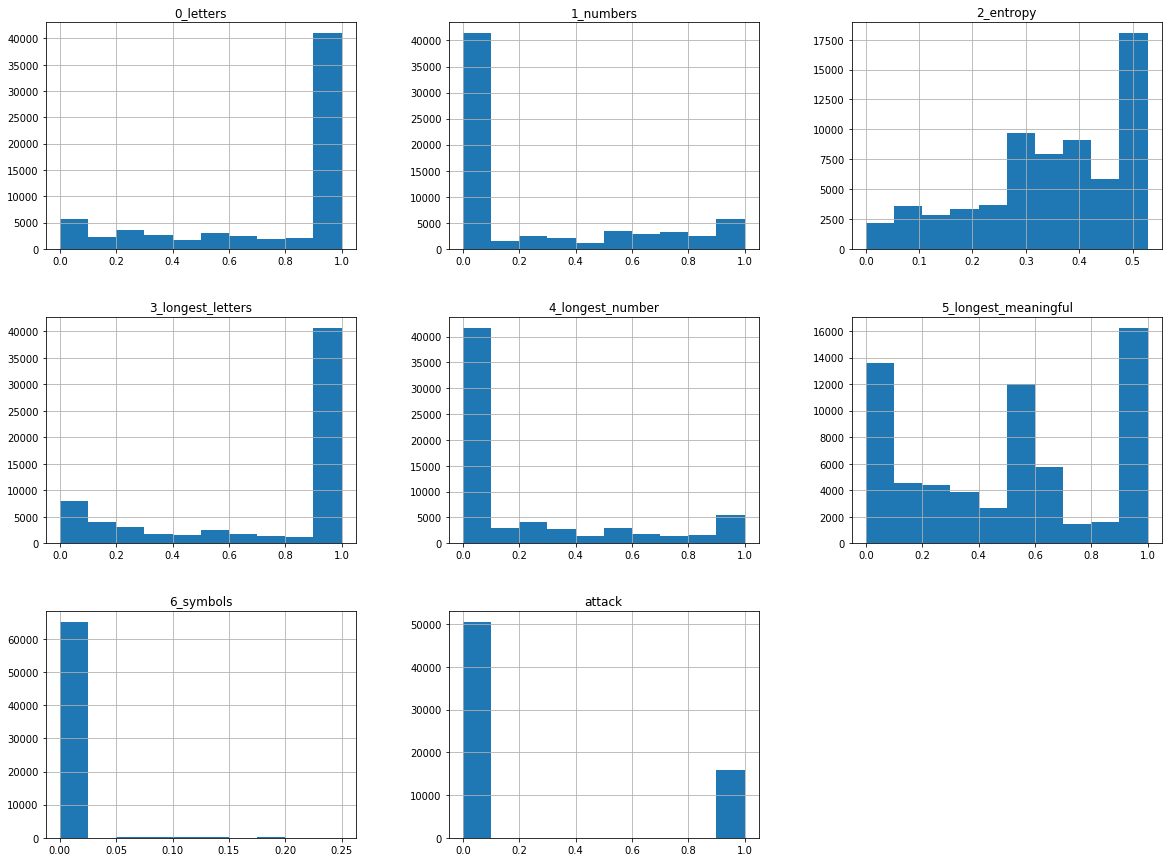

In [7]:
dns.hist(figsize=(20,15))
plt.show()

# Creación de un "test set"
Creación usando "stratified sampling" dependiendo si una consulta es un ataque o no.

In [8]:
train_set, test_set = split_train_and_test_sets(dns, 'attack')

In [9]:
train_set['attack'].value_counts() / len(train_set)

0    0.762007
1    0.237993
Name: attack, dtype: float64

In [10]:
test_set['attack'].value_counts() / len(test_set)

0    0.762002
1    0.237998
Name: attack, dtype: float64

El conjunto de entrenamiento y el conjunto de test tienen proporciones similares.

# Descubrir y visualizar los datos

In [11]:
train_set_copy = train_set.copy()

Buscando correlaciones: comprobemos si algún atributo se correlaciona con el atributo de ataque.

In [12]:
corr_matrix = train_set_copy.corr()
corr_matrix['attack'].sort_values(ascending=False)

attack                  1.000000
1_numbers               0.509387
4_longest_number        0.365384
6_symbols               0.043783
0_letters              -0.512202
2_entropy              -0.554315
3_longest_letters      -0.595368
5_longest_meaningful   -0.597897
Name: attack, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82e0519a20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f82e13126d8>]], dtype=object)

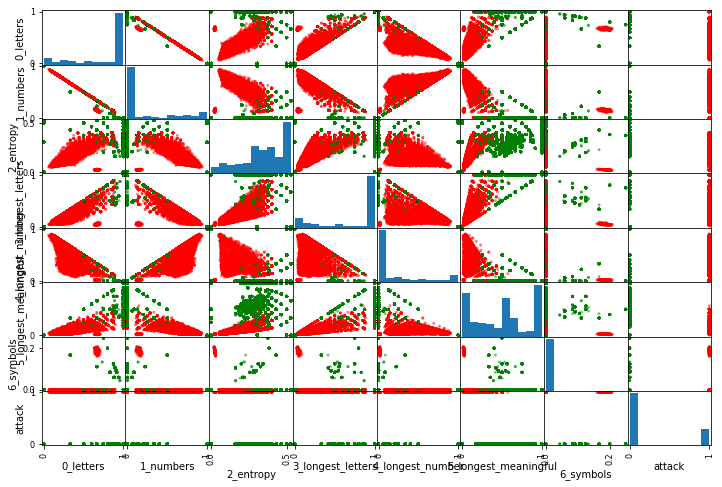

In [140]:
attributes = train_set_copy.columns
col_map = {0:'green', 1:'red'}
colours = list(map(lambda x:col_map.get(x), train_set_copy['attack']))
scatter_matrix(train_set_copy[attributes], figsize=(12, 8), c=colours)

# Selección y entrenamiento de modelos

En este apartado vamos a entrenar distintos tipos de modelos y haremos una selección de los que mejor rendimiento tengan.

In [14]:
features = train_set.drop('attack', 1)
features

,0_letters,1_numbers,2_entropy,3_longest_letters,4_longest_number,5_longest_meaningful,6_symbols
25768,1.000000,0.000000,0.264644,1.000000,0.000000,0.600000,0.000000
37417,0.454545,0.545455,0.264907,0.272727,0.272727,0.181818,0.000000
31869,0.102564,0.897436,0.074200,0.051282,0.820513,0.025641,0.000000
29250,0.222222,0.777778,0.121773,0.222222,0.777778,0.074074,0.000000
5628,1.000000,0.000000,0.528321,1.000000,0.000000,0.666667,0.000000
41523,1.000000,0.000000,0.319716,1.000000,0.000000,0.500000,0.000000
10726,0.437500,0.562500,0.203125,0.437500,0.562500,0.062500,0.000000
17188,1.000000,0.000000,0.233793,1.000000,0.000000,0.333333,0.000000
41428,0.666667,0.333333,0.528321,0.666667,0.333333,0.333333,0.000000
17725,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000


In [15]:
labels = train_set['attack']
labels

25768    0
37417    1
31869    1
29250    1
5628     0
41523    0
10726    1
17188    0
41428    0
17725    0
65197    1
20717    1
53768    0
63042    0
29075    0
38131    0
26017    0
10373    0
1100     0
16296    1
567      0
31346    0
59417    1
49793    0
2513     0
4714     0
26685    1
64763    0
8125     0
52343    0
        ..
22342    0
49929    0
34239    0
11798    0
10335    0
18409    0
10508    0
44793    0
25587    0
13502    0
34742    0
3059     0
59818    0
39518    0
17776    0
469      0
60297    1
25319    0
15151    0
9756     0
49333    1
12706    0
63567    0
48725    0
30374    0
41245    0
11775    0
13316    0
16502    0
35439    0
Name: attack, Length: 52989, dtype: int64

## Stochastic Gradient Descent (SGD) classifier

In [16]:
sgd_clf = SGDClassifier(max_iter=5, random_state=13)
sgd_clf.fit(features, labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=13, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
some_data = features[:10]
some_labels = labels[:10]
print("Predictions:", sgd_clf.predict(some_data))
print("Labels:", list(some_labels))

Predictions: [0 1 1 1 0 0 1 0 0 0]
Labels: [0, 1, 1, 1, 0, 0, 1, 0, 0, 0]


### Medida de Rendimiento

Evaluación del rendimiento usando una matriz de confusión.
"cross_val_predict" realiza "K-fold cross-validation" devolviendo las predicciones realizadas en cada "test fold".

In [18]:
train_predicted_labels = cross_val_predict(sgd_clf, features, labels, cv=5)

In [19]:
confusion_matrix(labels, train_predicted_labels)

array([[38651,  1727],
       [ 1371, 11240]])

Evaluación del rendimiento usando Precisión y Exhaustividad (Precision and Recall).

In [20]:
precision_score(labels, train_predicted_labels)

0.86681576309092312

In [21]:
recall_score(labels, train_predicted_labels)

0.89128538577432403

In [22]:
f1_score(labels, train_predicted_labels)

0.87888028774728277

### Análisis

Obtengamos la puntuación que el clasificador SGD da a todas las predicciones.

In [23]:
labels_scores = cross_val_predict(sgd_clf, features, labels, cv=5, method='decision_function')

In [24]:
labels_scores

array([-2.4201875 ,  3.10490297,  1.77679904, ..., -2.90352161,
       -4.97936237, -6.93869765])

Las puntuaciones viven entre los valores -7.79 y 8.57:

In [25]:
labels_scores.min()

-7.7916893225339248

In [26]:
labels_scores.max()

8.576393948289514

Tracemos la curva de precisión vs. exhaustividad.

In [27]:
precisions, recalls, thresholds = precision_recall_curve(labels, labels_scores)

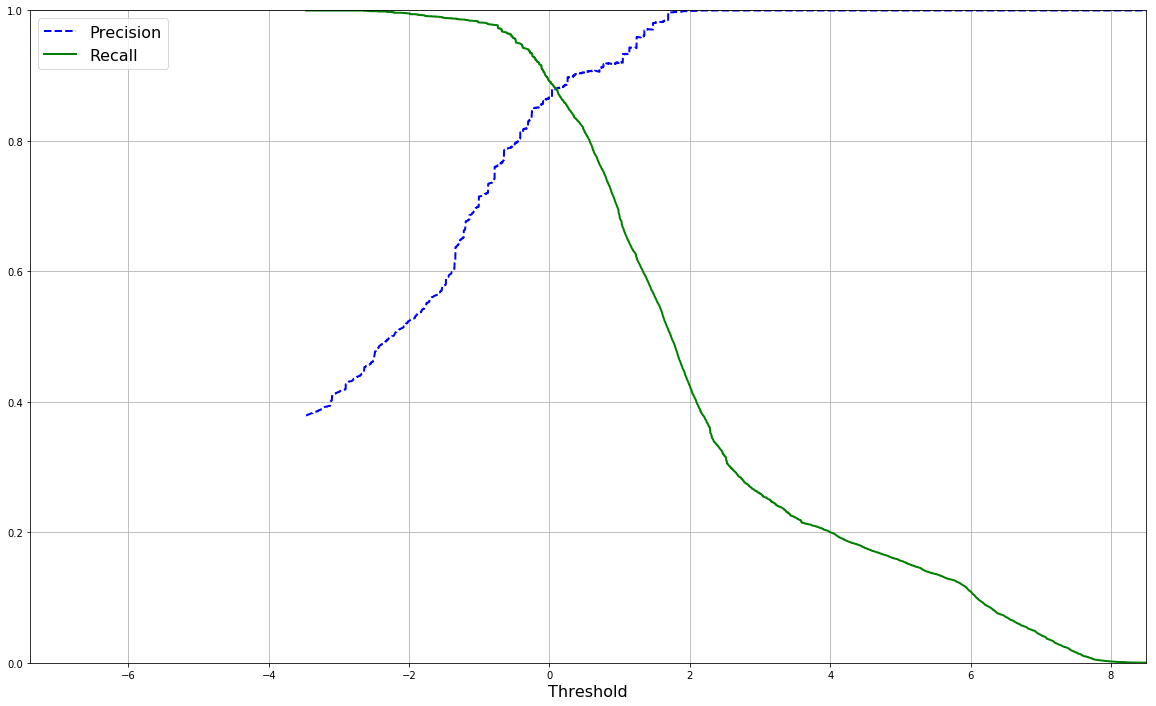

In [28]:
plt.figure(figsize=(20, 12))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-7.4, 8.5])
plt.show()

Con un valor cercano a 0 de umbral parece dar un resultado aceptable de precisión/exhaustividad:

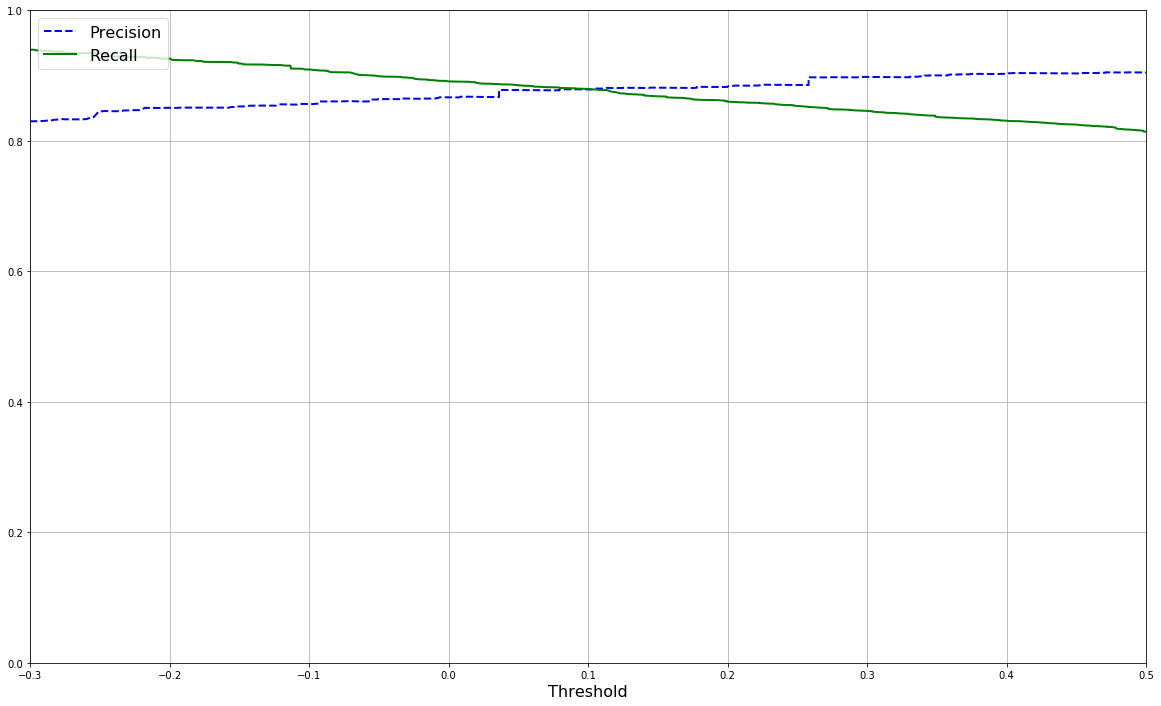

In [29]:
plt.figure(figsize=(20, 12))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-0.3, 0.5])
plt.show()

El valor 0 de umbral es el que el modelo usa por defecto para hacer las predicciones. Por lo tanto, las predicciones hechas por el modelo unos pasos más arriba ya usan el umbral óptimo. No es necesario hacer ningún ajuste.

## Logistic Regression classifier

In [30]:
log_reg_clf = LogisticRegression(random_state=13, solver='liblinear')
log_reg_clf.fit(features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=13, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
print("Predictions:", log_reg_clf.predict(some_data))
print("Labels:", list(some_labels))

Predictions: [0 1 1 1 0 0 1 0 0 0]
Labels: [0, 1, 1, 1, 0, 0, 1, 0, 0, 0]


### Medida de Rendimiento

Evaluación del rendimiento usando una matriz de confusión.

In [32]:
train_predicted_labels = cross_val_predict(log_reg_clf, features, labels, cv=5)

In [33]:
confusion_matrix(labels, train_predicted_labels)

array([[39185,  1193],
       [ 1814, 10797]])

Evaluación del rendimiento usando Precisión y Exhaustividad (Precision and Recall).

In [34]:
precision_score(labels, train_predicted_labels)

0.90050041701417849

In [35]:
recall_score(labels, train_predicted_labels)

0.85615732297200853

In [36]:
f1_score(labels, train_predicted_labels)

0.87776919637413109

### Análisis

Para poder representar gráficamente cómo actúa el modelo y analizarlo más fácilmente, dejemos sólo dos características: longest_letters y entropy.

In [37]:
reduced_features = features.drop(['0_letters', '1_numbers', '6_symbols', '4_longest_number', '5_longest_meaningful'], 1)
train_predicted_labels = cross_val_predict(log_reg_clf, reduced_features, labels, cv=5)

In [38]:
confusion_matrix(labels, train_predicted_labels)

array([[37973,  2405],
       [ 3995,  8616]])

Evaluación del rendimiento usando Precisión y Exhaustividad (Precision and Recall).

In [39]:
precision_score(labels, train_predicted_labels)

0.78178023772797389

In [40]:
recall_score(labels, train_predicted_labels)

0.68321306795654591

In [41]:
f1_score(labels, train_predicted_labels)

0.72918077183480046

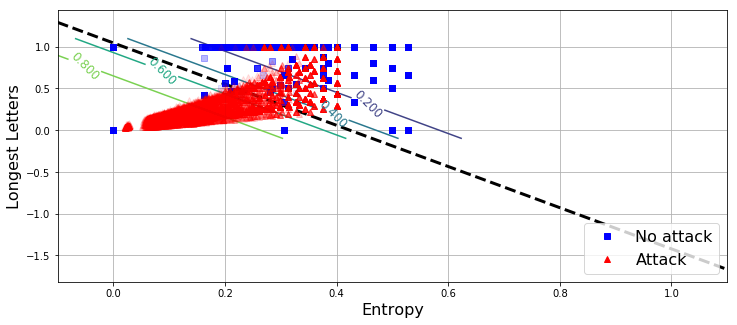

In [42]:
log_reg_clf.fit(reduced_features, labels)

plt.figure(figsize=(12, 5))

plot_predictions_for_logistic_regression(log_reg_clf, [-0.1, 1.1, -0.1, 1.1])

X = reduced_features.values
y = labels.values

plot_dataset(X, y, "Entropy", "Longest Letters")

plt.show()

## Support Vector Machines

* ## Con Polynomial Kernel

In [43]:
svm_clf_poly = SVC(kernel='poly', random_state=13, gamma='auto', degree=3, coef0=1, C=5)
svm_clf_poly.fit(features, labels)

SVC(C=5, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=13, shrinking=True,
  tol=0.001, verbose=False)

In [44]:
print("Predictions:", svm_clf_poly.predict(some_data))
print("Labels:", list(some_labels))

Predictions: [0 1 1 1 0 0 1 0 0 0]
Labels: [0, 1, 1, 1, 0, 0, 1, 0, 0, 0]


### Medida de Rendimiento

Evaluación del rendimiento usando una matriz de confusión.

In [45]:
train_predicted_labels = cross_val_predict(svm_clf_poly, features, labels, cv=5)

In [46]:
confusion_matrix(labels, train_predicted_labels)

array([[40149,   229],
       [  844, 11767]])

Evaluación del rendimiento usando Precisión y Exhaustividad (Precision and Recall).

In [47]:
precision_score(labels, train_predicted_labels)

0.98091030343447816

In [48]:
recall_score(labels, train_predicted_labels)

0.93307430021409876

In [49]:
f1_score(labels, train_predicted_labels)

0.95639452188401664

### Análisis

Volvamos a usar el vector que tiene sólo las dos características para facilitar el análisis.

In [50]:
train_predicted_labels = cross_val_predict(svm_clf_poly, reduced_features, labels, cv=5)

In [51]:
confusion_matrix(labels, train_predicted_labels)

array([[39016,  1362],
       [ 1053, 11558]])

Evaluación del rendimiento usando Precisión y Exhaustividad (Precision and Recall).

In [52]:
precision_score(labels, train_predicted_labels)

0.89458204334365321

In [53]:
recall_score(labels, train_predicted_labels)

0.91650146697327728

In [54]:
f1_score(labels, train_predicted_labels)

0.905409110493126

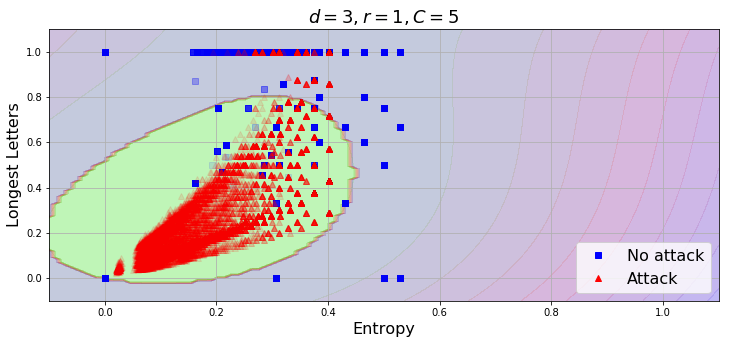

In [55]:
svm_clf_poly.fit(reduced_features, labels)

plt.figure(figsize=(12, 5))

plot_predictions_for_SVC(svm_clf_poly, [-0.1, 1.1, -0.1, 1.1]) 

plot_dataset(X, y, "Entropy", "Longest Letters")

plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.show()

Aumento del grado de la función polinómica del kernel y la penalización por error:

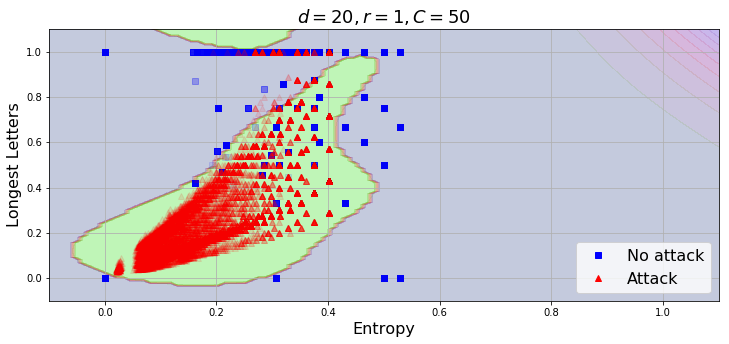

In [56]:
svm_clf_poly = SVC(kernel='poly', random_state=13, gamma='auto', degree=20, coef0=1, C=50)
svm_clf_poly.fit(reduced_features, labels)

plt.figure(figsize=(12, 5))

plot_predictions_for_SVC(svm_clf_poly, [-0.1, 1.1, -0.1, 1.1])

plot_dataset(X, y, "Entropy", "Longest Letters")

plt.title(r"$d=20, r=1, C=50$", fontsize=18)

plt.show()

* ## Con Gaussian RBF Kernel

In [57]:
svm_clf_rbf = SVC(kernel='rbf', random_state=13, gamma=5, C=5)
svm_clf_rbf.fit(features, labels)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=13, shrinking=True,
  tol=0.001, verbose=False)

In [58]:
print("Predictions:", svm_clf_rbf.predict(some_data))
print("Labels:", list(some_labels))

Predictions: [0 1 1 1 0 0 1 0 0 0]
Labels: [0, 1, 1, 1, 0, 0, 1, 0, 0, 0]


### Medida de Rendimiento

Evaluación del rendimiento usando una matriz de confusión.

In [59]:
train_predicted_labels = cross_val_predict(svm_clf_rbf, features, labels, cv=5)

In [60]:
confusion_matrix(labels, train_predicted_labels)

array([[40328,    50],
       [  705, 11906]])

Evaluación del rendimiento usando Precisión y Exhaustividad (Precision and Recall).

In [61]:
precision_score(labels, train_predicted_labels)

0.99581799933087989

In [62]:
recall_score(labels, train_predicted_labels)

0.94409642375703751

In [63]:
f1_score(labels, train_predicted_labels)

0.96926771685594493

### Análisis

Usemos de nuevo el vector con las características reducidas para la representación gráfica.

In [64]:
train_predicted_labels = cross_val_predict(svm_clf_rbf, reduced_features, labels, cv=5)

In [65]:
confusion_matrix(labels, train_predicted_labels)

array([[39433,   945],
       [ 1040, 11571]])

Evaluación del rendimiento usando Precisión y Exhaustividad (Precision and Recall).

In [66]:
precision_score(labels, train_predicted_labels)

0.92449664429530198

In [67]:
recall_score(labels, train_predicted_labels)

0.91753231306002692

In [68]:
f1_score(labels, train_predicted_labels)

0.92100131332829238

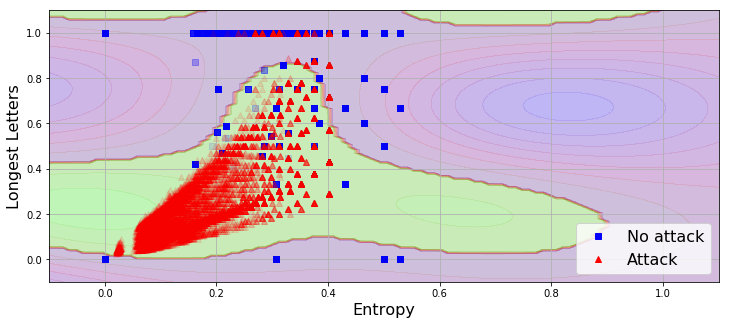

In [69]:
svm_clf_rbf.fit(reduced_features, labels)
plt.figure(figsize=(12, 5))

plot_predictions_for_SVC(svm_clf_rbf, [-0.1, 1.1, -0.1, 1.1])

plot_dataset(X, y, "Entropy", "Longest Letters")

plt.show()

## Decision Trees

In [70]:
tree_clf = DecisionTreeClassifier(random_state=13)
tree_clf.fit(features, labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best')

In [71]:
print("Predictions:", tree_clf.predict(some_data))
print("Labels:", list(some_labels))

Predictions: [0 1 1 1 0 0 1 0 0 0]
Labels: [0, 1, 1, 1, 0, 0, 1, 0, 0, 0]


### Medida de Rendimiento

Evaluación del rendimiento usando una matriz de confusión.

In [72]:
train_predicted_labels = cross_val_predict(tree_clf, features, labels, cv=5)

In [73]:
confusion_matrix(labels, train_predicted_labels)

array([[40344,    34],
       [  138, 12473]])

Evaluación del rendimiento usando Precisión y Exhaustividad (Precision and Recall).

In [74]:
precision_score(labels, train_predicted_labels)

0.99728152234748546

In [75]:
recall_score(labels, train_predicted_labels)

0.98905717230988821

In [76]:
f1_score(labels, train_predicted_labels)

0.99315232104466911

### Análisis

In [77]:
export_graphviz(
        tree_clf,
        out_file='../images/tree_clf_dns_entropy_tun.dot',
        feature_names=features.columns,
        class_names=['No attack', 'Attack'],
        rounded=True,
        filled=True
    )

![tree_clf_dns.png](../images/tree_clf_dns_entropy_tun.png "Árbol de decisión")

## K-Nearest-Neighbors

In [78]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(features, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [79]:
print("Predictions:", knn_clf.predict(some_data))
print("Labels:", list(some_labels))

Predictions: [0 1 1 1 0 0 1 0 0 0]
Labels: [0, 1, 1, 1, 0, 0, 1, 0, 0, 0]


### Medida de Rendimiento

Evaluación del rendimiento usando una matriz de confusión.

In [80]:
train_predicted_labels = cross_val_predict(knn_clf, features, labels, cv=5)

In [81]:
confusion_matrix(labels, train_predicted_labels)

array([[40292,    86],
       [  113, 12498]])

Evaluación del rendimiento usando Precisión y Exhaustividad (Precision and Recall).

In [82]:
precision_score(labels, train_predicted_labels)

0.99316592498410683

In [83]:
recall_score(labels, train_predicted_labels)

0.99103956863056064

In [84]:
f1_score(labels, train_predicted_labels)

0.99210160746179799

### Análisis

Hagamos una representación gráfica usando el vector con características reducidas.

In [85]:
train_predicted_labels = cross_val_predict(knn_clf, reduced_features, labels, cv=5)

In [86]:
confusion_matrix(labels, train_predicted_labels)

array([[40150,   228],
       [  804, 11807]])

Evaluación del rendimiento usando Precisión y Exhaustividad (Precision and Recall).

In [87]:
precision_score(labels, train_predicted_labels)

0.98105525550477768

In [88]:
recall_score(labels, train_predicted_labels)

0.93624613432717474

In [89]:
f1_score(labels, train_predicted_labels)

0.95812707944494035

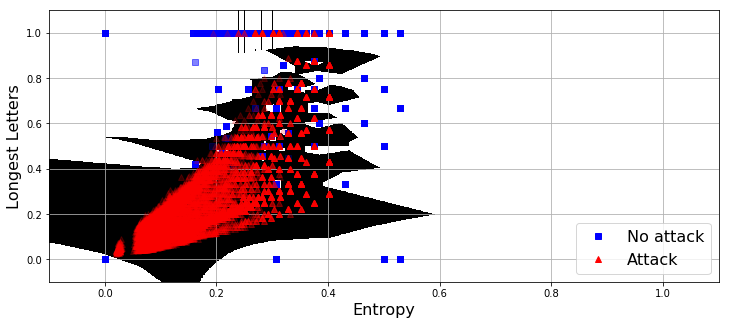

In [90]:
knn_clf_red = KNeighborsClassifier()
knn_clf_red.fit(reduced_features, labels)

plt.figure(figsize=(12, 5))

plot_predictions_for_KNN(knn_clf_red, [-0.1, 1.1, -0.1, 1.1])

plot_dataset(X, y, "Entropy", "Longest Letters", 0.2)

plt.show()

# Afinación de Modelos

## Support Vector Machines (Gaussian RBF Kernel)

### Randomized Search

In [91]:
svm_clf_rbf = SVC(kernel='rbf', random_state=13)
param_distribs = {
        'gamma': randint(low=1, high=100),
        'C': randint(low=1, high=500),
    }
svm_clf_rbf_rnd_search = RandomizedSearchCV(svm_clf_rbf, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='recall', random_state=13, return_train_score=False)
svm_clf_rbf_rnd_search.fit(features, labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=13,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f82e0604208>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f82e05a13c8>},
          pre_dispatch='2*n_jobs', random_state=13, refit=True,
          return_train_score=False, scoring='recall', verbose=0)

In [92]:
search_results = svm_clf_rbf_rnd_search.cv_results_
for mean_score, params in zip(search_results['mean_test_score'], search_results['params']):
    print(mean_score, params)

0.987788410305 {'C': 339, 'gamma': 49}
0.989453710364 {'C': 75, 'gamma': 17}
0.98810560989 {'C': 231, 'gamma': 99}
0.989532976588 {'C': 245, 'gamma': 26}
0.987867713942 {'C': 237, 'gamma': 59}
0.98842277804 {'C': 484, 'gamma': 27}
0.987947010097 {'C': 245, 'gamma': 67}
0.987867713942 {'C': 431, 'gamma': 55}
0.988026313735 {'C': 230, 'gamma': 78}
0.987947010097 {'C': 75, 'gamma': 74}


A partir de estos datos, al realizar el "Grid Search" nos centraremos en los valores de "C" y "gamma" más bajos, para evitar el sobreajuste ("overfitting").

### Grid Search

In [93]:
param_grid = {'C': [10, 20, 30, 50], 'gamma': [1, 10, 20, 50]}
svm_clf_rbf_grid_search = GridSearchCV(svm_clf_rbf, param_grid, cv=5, scoring='recall', return_train_score=False)
svm_clf_rbf_grid_search.fit(features, labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=13,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [10, 20, 30, 50], 'gamma': [1, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='recall', verbose=0)

In [94]:
search_results = svm_clf_rbf_grid_search.cv_results_
for mean_score, params in zip(search_results['mean_test_score'], search_results['params']):
    print(mean_score, params)

0.943065623717 {'C': 10, 'gamma': 1}
0.944889316984 {'C': 10, 'gamma': 10}
0.98826418573 {'C': 10, 'gamma': 20}
0.990722405413 {'C': 10, 'gamma': 50}
0.942748428607 {'C': 20, 'gamma': 1}
0.969153342707 {'C': 20, 'gamma': 10}
0.988502096643 {'C': 20, 'gamma': 20}
0.988819266297 {'C': 20, 'gamma': 50}
0.94274843609 {'C': 30, 'gamma': 1}
0.97970042721 {'C': 30, 'gamma': 10}
0.989057222107 {'C': 30, 'gamma': 20}
0.988184897058 {'C': 30, 'gamma': 50}
0.942589797379 {'C': 50, 'gamma': 1}
0.981682569074 {'C': 50, 'gamma': 10}
0.990008763971 {'C': 50, 'gamma': 20}
0.987947010097 {'C': 50, 'gamma': 50}


Los valores de C=10 y gamma=20 parecen dar un resultado aceptable.

## Decision Trees

### Randomized Search

In [95]:
param_distribs = {
        'max_depth': randint(low=5, high=10),
        'min_samples_split': randint(low=12, high=25),
        'min_samples_leaf': randint(low=3, high=8)
    }
tree_clf_rnd_search = RandomizedSearchCV(tree_clf, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='recall', random_state=13, return_train_score=False)
tree_clf_rnd_search.fit(features, labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f82e0584320>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f82e0584e10>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f82e0584908>},
          pre_dispatch='2*n_jobs', random_state=13, refit=True,
          return_train_score=False, scoring='recall', verbose=0)

In [96]:
search_results = tree_clf_rnd_search.cv_results_
for mean_score, params in zip(search_results['mean_test_score'], search_results['params']):
    print(mean_score, params)

0.985171342355 {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 22}
0.98826403754 {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 16}
0.987867654079 {'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 22}
0.990960260938 {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 16}
0.985171342355 {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 21}
0.99119814192 {'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 14}
0.98826403754 {'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 17}
0.99103954961 {'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 18}
0.991118860731 {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 14}
0.98826403754 {'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 23}


Al añadir estos parámetros al árbol de decisión nos encontramos con valores más bajos de exahustividad que cuando el modelo no tenía parámetros. Es muy probable que el modelo sin parámetros estuviera sobreajustado, debido al propio funcionamiento del modelo. Si un árbol de decisión se deja sin restricciones, éste tenderá a ajustarse a los datos, adaptándose a ellos de forma muy cercana. Por lo tanto, hay muchas posibilidades de que un árbol de decisión sin restricciones estará sobreajustado.
Debido a esto, añadiremos algunos parámetros a nuestro árbol para que pueda generalizar más con nuevos conjuntos de datos.

### Grid Search

In [97]:
param_grid = {'max_depth': [7], 'min_samples_leaf': [2, 4, 5], 'min_samples_split': [12, 14, 18]}
tree_clf_grid_search = GridSearchCV(tree_clf, param_grid, cv=5, scoring='recall', return_train_score=False)
tree_clf_grid_search.fit(features, labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [7], 'min_samples_leaf': [2, 4, 5], 'min_samples_split': [12, 14, 18]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='recall', verbose=0)

In [98]:
search_results = tree_clf_grid_search.cv_results_
for mean_score, params in zip(search_results['mean_test_score'], search_results['params']):
    print(mean_score, params)

0.985171342355 {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 12}
0.985171342355 {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 14}
0.985171342355 {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 18}
0.985171342355 {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 12}
0.985171342355 {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 14}
0.985171342355 {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 18}
0.985171342355 {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 12}
0.985171342355 {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 14}
0.985171342355 {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 18}


El resultado son valores idénticos de exahustividad. Para que el árbol de decisión generalice lo máximo posible, trataremos de maximizar los parámetros "min_\*" y minimizar los parámetros "max_\*".

## K-Nearest-Neighbors

### Randomized Search

In [99]:
param_distribs = {
        'n_neighbors': randint(low=1, high=50),
        'weights': ['distance']
    }
knn_clf_rnd_search = RandomizedSearchCV(knn_clf, param_distributions=param_distribs,
                                n_iter=5, cv=5, scoring='recall', random_state=13, return_train_score=False)
knn_clf_rnd_search.fit(features, labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid='warn', n_iter=5, n_jobs=None,
          param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f82e05969b0>, 'weights': ['distance']},
          pre_dispatch='2*n_jobs', random_state=13, refit=True,
          return_train_score=False, scoring='recall', verbose=0)

In [100]:
search_results = knn_clf_rnd_search.cv_results_
for mean_score, params in zip(search_results['mean_test_score'], search_results['params']):
    print(mean_score, params)

0.989929351062 {'n_neighbors': 19, 'weights': 'distance'}
0.989295032736 {'n_neighbors': 49, 'weights': 'distance'}
0.991356657862 {'n_neighbors': 11, 'weights': 'distance'}
0.990008647217 {'n_neighbors': 17, 'weights': 'distance'}
0.989215736581 {'n_neighbors': 39, 'weights': 'distance'}


Usando el parámetro "distance" cambiamos el peso usado en la predicción. El peso por defecto es uniforme, por lo que cada vecino tiene el mismo peso. Al hacer este cambio, el peso de un vecino es calculado con la inversa de su distancia. Por lo tanto, los vecinos más cercanos tendrán más peso.

### Grid Search

In [101]:
param_grid = {'n_neighbors': [3, 7, 15], 'weights': ['uniform', 'distance']}
knn_clf_grid_search = GridSearchCV(knn_clf, param_grid, cv=5, scoring='recall', return_train_score=False)
knn_clf_grid_search.fit(features, labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [3, 7, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='recall', verbose=0)

In [102]:
search_results = knn_clf_grid_search.cv_results_
for mean_score, params in zip(search_results['mean_test_score'], search_results['params']):
    print(mean_score, params)

0.987075430614 {'n_neighbors': 3, 'weights': 'uniform'}
0.987234006454 {'n_neighbors': 3, 'weights': 'distance'}
0.98929513302 {'n_neighbors': 7, 'weights': 'uniform'}
0.989850173165 {'n_neighbors': 7, 'weights': 'distance'}
0.989374411202 {'n_neighbors': 15, 'weights': 'uniform'}
0.991356809059 {'n_neighbors': 15, 'weights': 'distance'}


No parece haber una gran variación en la exhaustividad, trataremos de adoptar un valor de número de vecinos intermedio para evitar el sobreajuste o el subajuste.

# Ensemble Learning

Debido a que ya hemos estrechado nuestras opciones con respecto a qué modelos usar y hemos ajustado los modelos más prometedores, ahora podemos probar a combinar varios modelos para ver si al ser usados conjuntamente, aumenta su rendimiento.

## Modelos Elegidos

Elegiremos los modelos con los siguientes parámetros:
- Support Vector Machines (Gaussian RBF Kernel): {'C': 10, 'gamma': 20}. Exhaustividad: 0.98.
- Decision Trees: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 14}. Exhaustividad: 0.98.
- K-Nearest-Neighbors: parámetros por defecto ({'n_neighbors': 5, 'weights': 'uniform'}). Exhaustividad: 0.99.

In [103]:
svm_clf_rbf_tuned = SVC(kernel='rbf', random_state=13, gamma=20, C=10)
svm_clf_rbf_tuned.fit(features, labels)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=20, kernel='rbf',
  max_iter=-1, probability=False, random_state=13, shrinking=True,
  tol=0.001, verbose=False)

In [104]:
tree_clf_tuned = DecisionTreeClassifier(random_state=13, max_depth=7, min_samples_leaf=4, min_samples_split=14)
tree_clf_tuned.fit(features, labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=14,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best')

In [105]:
knn_clf

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

## Voting Classifiers

Usa la técnica de agregar las predicciones de diferentes clasificadores seleccionando la clase que obtiene más votos.

### SVM + Decision Tree + KNN

In [106]:
voting_clf_s_d_k = VotingClassifier(
    estimators=[('svm', svm_clf_rbf_tuned), ('dt', tree_clf_tuned), ('knn', knn_clf)], voting='hard')
voting_clf_s_d_k.fit(features, labels)

VotingClassifier(estimators=[('svm', SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=20, kernel='rbf',
  max_iter=-1, probability=False, random_state=13, shrinking=True,
  tol=0.001, verbose=False)), ('dt', DecisionTreeClassifier(class_weight=None, criterion='...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

### Medida de Rendimiento

Evaluación del rendimiento usando una matriz de confusión.

In [107]:
train_predicted_labels = cross_val_predict(voting_clf_s_d_k, features, labels, cv=5)

In [108]:
confusion_matrix(labels, train_predicted_labels)

array([[40155,   223],
       [  135, 12476]])

Evaluación del rendimiento usando Precisión y Exhaustividad (Precision and Recall).

In [109]:
precision_score(labels, train_predicted_labels)

0.98243956217024964

In [110]:
recall_score(labels, train_predicted_labels)

0.98929505986836885

In [111]:
f1_score(labels, train_predicted_labels)

0.98585539312524695

### Decision Tree + KNN

In [112]:
voting_clf_d_k = VotingClassifier(
    estimators=[('dt', tree_clf_tuned), ('knn', knn_clf)], voting='soft')
voting_clf_d_k.fit(features, labels)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=14,
            min_weight_fraction_leaf=0...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

### Medida de Rendimiento

Evaluación del rendimiento usando una matriz de confusión.

In [113]:
train_predicted_labels = cross_val_predict(voting_clf_d_k, features, labels, cv=5)

In [114]:
confusion_matrix(labels, train_predicted_labels)

array([[40280,    98],
       [  115, 12496]])

Evaluación del rendimiento usando Precisión y Exhaustividad (Precision and Recall).

In [115]:
precision_score(labels, train_predicted_labels)

0.99221851675400985

In [116]:
recall_score(labels, train_predicted_labels)

0.99088097692490684

In [117]:
f1_score(labels, train_predicted_labels)

0.9915492957746479

## Random Forests

La técnica anterior se sirve de varios algoritmos para realizar predicciones, utilizando el mismo conjunto de datos de aprendizaje. Otras técnicas de "ensemble learning" son "bagging" y "pasting". Éstas consisten en entrenar el mismo algoritmo pero con distintos subconjuntos de los datos de entrenamiento.

"Bagging" y "pasting" permiten que las instancias de entrenamiento sean usadas varias veces por diferentes predictores, pero solo "bagging" permite que una instancia sea usada varias veces por el mismo predictor. Son usadas mayormente con árboles de decisión, aunque se pueden usar con cualquier tipo de modelo. En este caso usaremos árboles de decisión creando el enfoque llamado "random forests".

In [118]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=13)
rnd_clf.fit(features, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

### Medida de Rendimiento

Evaluación del rendimiento usando una matriz de confusión.

In [119]:
train_predicted_labels = cross_val_predict(rnd_clf, features, labels, cv=5)

In [120]:
confusion_matrix(labels, train_predicted_labels)

array([[40307,    71],
       [  445, 12166]])

Evaluación del rendimiento usando Precisión y Exhaustividad (Precision and Recall).

In [121]:
precision_score(labels, train_predicted_labels)

0.99419792432785814

In [122]:
recall_score(labels, train_predicted_labels)

0.9647133454920308

In [123]:
f1_score(labels, train_predicted_labels)

0.97923374114616868

## Extremely Randomized Trees

Una técnica muy similar a "random forests" pero añade más aleatoriedad ya que la elección de los umbrales para cada característica se realiza de forma aleatoria.

In [124]:
extra_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=13)
extra_clf.fit(features, labels)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=16,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

### Medida de Rendimiento

Evaluación del rendimiento usando una matriz de confusión.

In [125]:
train_predicted_labels = cross_val_predict(extra_clf, features, labels, cv=5)

In [126]:
confusion_matrix(labels, train_predicted_labels)

array([[40295,    83],
       [  708, 11903]])

Evaluación del rendimiento usando Precisión y Exhaustividad (Precision and Recall).

In [127]:
precision_score(labels, train_predicted_labels)

0.99307525446354084

In [128]:
recall_score(labels, train_predicted_labels)

0.94385853619855686

In [129]:
f1_score(labels, train_predicted_labels)

0.96784160670000396

# Evaluar los Modelos con el "Test Set"

Después de probar varios modelos, seleccionar los mejores, ajustarlos y comprobar cómo funcionan cuando son combinados, podemos analizar su rendimiento usando el conjunto de datos que apartamos al principio como "test set". Los modelos nunca han visto esos datos, por lo tanto podemos ver como reaccionan con nuevos datos.

In [130]:
features_test = test_set.drop('attack', 1)

In [131]:
labels_test = test_set['attack']

## Support Vector Machines (Gaussian RBF Kernel)

In [132]:
final_precision, final_recall, final_f1, final_confusion_matrix = evaluate_model_with_precision_and_recall(
    svm_clf_rbf_tuned, features_test, labels_test)
print("Precision: ", final_precision, "\nRecall: ", final_recall, "\nF1: ", final_f1, "\n\n", final_confusion_matrix)

Precision:  0.970423412204 
Recall:  0.988582302569 
F1:  0.979418695994 

 [[10000    95]
 [   36  3117]]


## Decision Trees

In [133]:
final_precision, final_recall, final_f1, final_confusion_matrix = evaluate_model_with_precision_and_recall(
    tree_clf_tuned, features_test, labels_test)
print("Precision: ", final_precision, "\nRecall: ", final_recall, "\nF1: ", final_f1, "\n\n", final_confusion_matrix)

Precision:  0.976766091052 
Recall:  0.986679352997 
F1:  0.981697696434 

 [[10021    74]
 [   42  3111]]


## K-Nearest-Neighbors

In [134]:
final_precision, final_recall, final_f1, final_confusion_matrix = evaluate_model_with_precision_and_recall(
    knn_clf, features_test, labels_test)
print("Precision: ", final_precision, "\nRecall: ", final_recall, "\nF1: ", final_f1, "\n\n", final_confusion_matrix)

Precision:  0.993616342164 
Recall:  0.987313669521 
F1:  0.990454979319 

 [[10075    20]
 [   40  3113]]


## SVM + Decision Tree + KNN

In [135]:
final_precision, final_recall, final_f1, final_confusion_matrix = evaluate_model_with_precision_and_recall(
    voting_clf_s_d_k, features_test, labels_test)
print("Precision: ", final_precision, "\nRecall: ", final_recall, "\nF1: ", final_f1, "\n\n", final_confusion_matrix)

Precision:  0.976766091052 
Recall:  0.986679352997 
F1:  0.981697696434 

 [[10021    74]
 [   42  3111]]


## Decision Tree + KNN

In [136]:
final_precision, final_recall, final_f1, final_confusion_matrix = evaluate_model_with_precision_and_recall(
    voting_clf_d_k, features_test, labels_test)
print("Precision: ", final_precision, "\nRecall: ", final_recall, "\nF1: ", final_f1, "\n\n", final_confusion_matrix)

Precision:  0.993614303959 
Recall:  0.986996511259 
F1:  0.990294351631 

 [[10075    20]
 [   41  3112]]


## Random Forests

In [137]:
final_precision, final_recall, final_f1, final_confusion_matrix = evaluate_model_with_precision_and_recall(
    rnd_clf, features_test, labels_test)
print("Precision: ", final_precision, "\nRecall: ", final_recall, "\nF1: ", final_f1, "\n\n", final_confusion_matrix)

Precision:  0.995748855461 
Recall:  0.965746907707 
F1:  0.980518435035 

 [[10082    13]
 [  108  3045]]


## Extremely Randomized Trees

In [138]:
final_precision, final_recall, final_f1, final_confusion_matrix = evaluate_model_with_precision_and_recall(
    extra_clf, features_test, labels_test)
print("Precision: ", final_precision, "\nRecall: ", final_recall, "\nF1: ", final_f1, "\n\n", final_confusion_matrix)

Precision:  0.995666666667 
Recall:  0.947351728513 
F1:  0.970908499919 

 [[10082    13]
 [  166  2987]]


In [139]:
directory = '../models/extract_features_entropy_and_ratios/'
joblib.dump(voting_clf_d_k, directory + 'tunn_decision_trees+knn.pkl')
joblib.dump(knn_clf, directory + 'tunn_knn.pkl')
joblib.dump(voting_clf_s_d_k, directory + 'tunn_svm+decision_trees+knn.pkl')
joblib.dump(svm_clf_rbf_tuned, directory + 'tunn_svm_rbf.pkl')

['../models/extract_features_entropy_and_ratios/tunn_svm_rbf.pkl']